In [1]:
# !wget https://raw.githubusercontent.com/huseinzol05/project-suka-suka/main/mysejahtera-hotspot/data/Federal%20Territory%20of%20Kuala%20Lumpur-points.json-points-cases.json
# https://pysal.org/esda/notebooks/adbscan_berlin_example.html

In [2]:
import json
import pandas as pd
import geopandas
from shapely.geometry import Point
from geopandas import GeoDataFrame
import libpysal as lps
import numpy as np
import contextily as cx

/usr/lib/python3/dist-packages/requests/__init__.py:80: RequestsDependencyWarning: urllib3 (1.22) or chardet (4.0.0) doesn't match a supported version!
  RequestsDependencyWarning)


In [3]:
import warnings
import pandas
import numpy as np
from libpysal.cg.alpha_shapes import alpha_shape_auto
from scipy.spatial import cKDTree
from collections import Counter
from sklearn.cluster import DBSCAN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.base import BaseEstimator as _BaseEstimator, ClusterMixin as _ClusterMixin

In [4]:
from adbscan import ADBSCAN, get_cluster_boundary, remap_lbls

In [5]:
with open('Federal Territory of Kuala Lumpur-points.json-points-cases.json') as fopen:
    data = json.load(fopen)
    
df = pd.DataFrame(data)
df.head()

,0,1,2
0,3.044052,101.670963,28
1,3.044052,101.674963,23
2,3.044052,101.678963,13
3,3.044052,101.682963,17
4,3.044052,101.686963,17


In [8]:
nonzero = df[2][df[2] > 0]
nonzero.describe(percentiles = np.arange(0, 1.1, step = 0.1))

count    1203.000000
mean       80.275977
std        65.439601
min         1.000000
0%          1.000000
10%        14.000000
20%        27.000000
30%        38.000000
40%        50.000000
50%        64.000000
60%        77.000000
70%        99.000000
80%       128.600000
90%       171.000000
100%      431.000000
max       431.000000
Name: 2, dtype: float64

In [9]:
import math

def euclidean_distance(x1, x2):
    dist = [(a - b)**2 for a, b in zip(x1, x2)]
    return math.sqrt(sum(dist))

In [13]:
from collections import defaultdict

# modified version of DBSCAN, defined deterministic boundary
class DBSCAN_with_boundary:
    def __init__(self, min_samples=3,
                 epsilon=0.005,
                 boundaries = [[1,14], [14,27],[27,38],[38,50],[50,64],
                              [64,77],[77,99],[99,128],[128,171],[171,431 + 1]]):
        
        self.min_samples = min_samples
        self.epsilon = epsilon
        self.boundaries = boundaries
        
    def _neighbors(self, sample_i, boundary):
        neighbors = []
        ids = np.arange(self.X.shape[0])
        for i in range(len(self.X)):
            if i == sample_i:
                continue
            if euclidean_distance(self.X[sample_i],self.X[i]) < self.epsilon and \
            self.Y[i] >= boundary[0] and self.Y[i] < boundary[1]:
                neighbors.append(i)
                
        return np.array(neighbors)
    
    def _expand(self, sample_i, neighbors, boundary):
        cluster = [sample_i]
        for i in neighbors:
            if i not in self.visited_samples:
                self.visited_samples.append(i)
                self.neighbors[i] = self._neighbors(i, boundary)
                if len(self.neighbors[i]) >= self.min_samples:
                    expanded_cluster = self._expand(i,self.neighbors[i], boundary)
                    cluster = cluster + expanded_cluster
                else:
                    cluster.append(i)
        return cluster
    
    def fit_predict(self, X, Y):
        self.X = X
        self.Y = Y
        self.clusters = defaultdict(list)
        n_samples = self.X.shape[0]
        for no, b in enumerate(self.boundaries):
            print(no, b)
            self.neighbors = {}
            self.visited_samples = []
            for i in range(n_samples):
                self.neighbors[i] = self._neighbors(i, b)
                if len(self.neighbors[i]) >= self.min_samples:
                    self.visited_samples.append(i)
                    new_cluster = self._expand(i,self.neighbors[i], b)
                    if len(new_cluster) >= self.min_samples:
                        self.clusters[no].append(new_cluster)

In [14]:
dbscan = DBSCAN_with_boundary()
dbscan.fit_predict(df[[0,1]].values, df[2])

0 [1, 14]
1 [14, 27]
2 [27, 38]
3 [38, 50]
4 [50, 64]
5 [64, 77]
6 [77, 99]
7 [99, 128]
8 [128, 171]
9 [171, 432]


In [15]:
geopandas.points_from_xy(df[1], df[0])[0].x

101.670963

In [16]:
geometry = [Point(xy) for xy in zip(df[0], df[1])]
crs = {'init': 'epsg:4326'}
bl_gdf = GeoDataFrame(df, crs=crs, geometry=geopandas.points_from_xy(df[1], df[0]))

/home/ubuntu/.local/lib/python3.7/site-packages/pyproj/crs/crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [17]:
db = bl_gdf.to_crs(epsg=5243)

<AxesSubplot:>

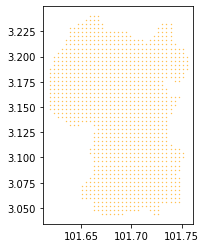

In [18]:
db.to_crs('crs').plot(markersize=0.1, color='orange')

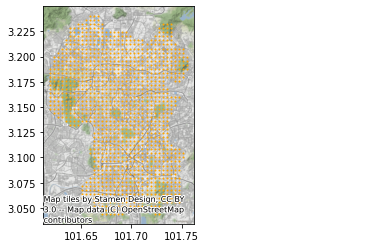

In [19]:
ax = db.to_crs('crs').plot(markersize=1.0, color='orange')
cx.add_basemap(ax, crs=db.to_crs('crs').crs.to_string());

In [20]:
db["X"] = db.geometry.x
db["Y"] = db.geometry.y

In [21]:
from libpysal.cg.alpha_shapes import alpha_shape_auto

def get_cluster_boundary(labels, xys, scores, xy=["X", "Y"], n_jobs=1, crs=None, step=1):
    try:
        from geopandas import GeoSeries
    except ModuleNotFoundError:

        def GeoSeries(data, index=None, crs=None):
            return list(data)

    lbl_type = type(labels.iloc[0])
    noise = lbl_type(-1)
    ids_in_cluster = labels[labels != noise].index
    g = xys.loc[ids_in_cluster, xy].groupby(labels[ids_in_cluster])
    chunked_pts_step = []
    cluster_lbls = []
    y, totals = [], []
    for sub in g.groups:
        chunked_pts_step.append((xys.loc[g.groups[sub], xy].values, step))
        y.append(scores.loc[g.groups[sub]].mean())
        totals.append(scores.loc[g.groups[sub]].shape[0])
        cluster_lbls.append(sub)
    if n_jobs == 1:
        polys = map(_asa, chunked_pts_step)
    else:
        pool = _setup_pool(n_jobs)
        polys = pool.map(_asa, chunked_pts_step)
        pool.close()
    polys = GeoSeries(polys, index=cluster_lbls, crs=crs)
    return polys, y, totals


def _asa(pts_s):
    return alpha_shape_auto(pts_s[0], step=pts_s[1])

/home/ubuntu/.local/lib/python3.7/site-packages/libpysal/cg/alpha_shapes.py:574: UserWarning: Numba not imported, so alpha shape construction may be slower than expected.
  warn(NUMBA_WARN)
/home/ubuntu/.local/lib/python3.7/site-packages/libpysal/cg/alpha_shapes.py:117: RuntimeWarning: invalid value encountered in sqrt
  den = np.sqrt((ab + bc + ca) * (bc + ca - ab) * (ca + ab - bc) * (ab + bc - ca))


CPU times: user 1.99 s, sys: 52 ms, total: 2.04 s
Wall time: 3.19 s


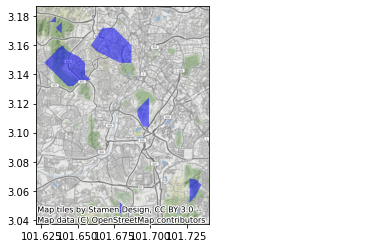

In [22]:
%%time

labels = np.full(shape=df.shape[0], fill_value=-1)
for i, cluster in enumerate(dbscan.clusters[0]):
    for sample in cluster:
        labels[sample] = i + 1
        
polys0, y0, totals0 = get_cluster_boundary(pd.Series(labels), db, db[2], crs=db.crs)
polys0 = polys0.to_crs('crs')
ax = polys0.plot(alpha=0.5, color="blue")
cx.add_basemap(ax, crs=polys0.crs.to_string());

In [23]:
y0, totals0

([11.5,
  7.9,
  8.307692307692308,
  6.818181818181818,
  6.833333333333333,
  8.0,
  2.6666666666666665],
 [4, 10, 13, 33, 30, 4, 3])

/home/ubuntu/.local/lib/python3.7/site-packages/libpysal/cg/alpha_shapes.py:574: UserWarning: Numba not imported, so alpha shape construction may be slower than expected.
  warn(NUMBA_WARN)
/home/ubuntu/.local/lib/python3.7/site-packages/libpysal/cg/alpha_shapes.py:117: RuntimeWarning: invalid value encountered in sqrt
  den = np.sqrt((ab + bc + ca) * (bc + ca - ab) * (ca + ab - bc) * (ab + bc - ca))
/home/ubuntu/.local/lib/python3.7/site-packages/libpysal/cg/alpha_shapes.py:628: RuntimeWarning: divide by zero encountered in double_scalars
  alpha = (1 / radi) - EPS


CPU times: user 1.95 s, sys: 40.1 ms, total: 1.99 s
Wall time: 2.84 s


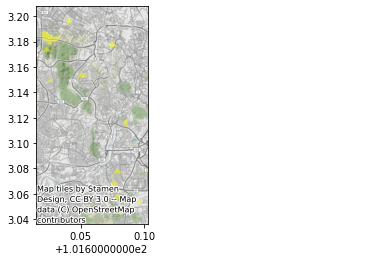

In [24]:
%%time

labels = np.full(shape=df.shape[0], fill_value=-1)
for i, cluster in enumerate(dbscan.clusters[1]):
    for sample in cluster:
        labels[sample] = i + 1
        
polys1, y1, totals1 = get_cluster_boundary(pd.Series(labels), db, db[2], crs=db.crs)
polys1 = polys1.to_crs('crs')
ax = polys1.plot(alpha=0.5, color="yellow")
cx.add_basemap(ax, crs=polys1.crs.to_string());

In [25]:
y1, totals1

([17.0,
  19.333333333333332,
  20.333333333333332,
  17.25,
  19.5,
  20.25,
  23.75,
  14.25,
  15.75,
  20.0,
  19.272727272727273,
  17.75,
  19.75],
 [4, 3, 3, 4, 6, 4, 4, 4, 4, 4, 11, 4, 4])

/home/ubuntu/.local/lib/python3.7/site-packages/libpysal/cg/alpha_shapes.py:574: UserWarning: Numba not imported, so alpha shape construction may be slower than expected.
  warn(NUMBA_WARN)


CPU times: user 3.16 s, sys: 184 ms, total: 3.34 s
Wall time: 33.2 s


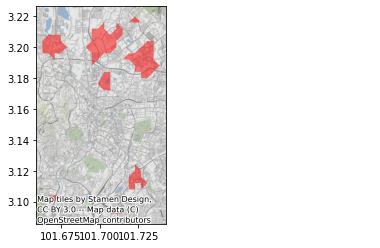

In [29]:
%%time

labels = np.full(shape=df.shape[0], fill_value=-1)
for i, cluster in enumerate(dbscan.clusters[9]):
    for sample in cluster:
        labels[sample] = i + 1
        
polys2, y2, totals2 = get_cluster_boundary(pd.Series(labels), db, db[2], crs=db.crs)
polys2 = polys2.to_crs('crs')
ax = polys2.plot(alpha=0.5, color="red")
cx.add_basemap(ax, crs=polys2.crs.to_string());

In [27]:
y2, totals2

([35.25,
  33.25,
  32.75,
  32.6,
  34.666666666666664,
  32.22222222222222,
  28.666666666666668,
  34.75,
  35.5,
  34.0],
 [4, 4, 4, 5, 3, 9, 3, 4, 4, 4])

In [28]:
!mkdir data

mkdir: cannot create directory ‘data’: File exists


In [32]:
len(dbscan.clusters)

10

In [38]:
results = {}
color = {0: '#0000FF', 1: '#0000FF', 2: '#0000FF', 3: '#0000FF',
        4: '#FFFF00', 5: '#FFFF00', 6: '#FFFF00',
        7: '#FF0000', 8: '#FF0000', 9: '#FF0000'}

for i in range(len(dbscan.clusters)):
    
    labels = np.full(shape=df.shape[0], fill_value=-1)
    for no, cluster in enumerate(dbscan.clusters[i]):
        for sample in cluster:
            labels[sample] = no + 1

    polys, ys, totals = get_cluster_boundary(pd.Series(labels), db, db[2], crs=db.crs)
    polys = polys.to_crs('crs')
    
    polygons = []
    for k in range(len(polys)):
        polygons_ = []
        x, y = polys.iloc[k].exterior.coords.xy
        for x_, y_ in zip(x, y):
            polygons_.append({'lat': y_, 'lng': x_})
        polygons.append(polygons_)
        
    results[i] = {'polygons': polygons, 'data': [ys, totals], 'color': color[i]}

/home/ubuntu/.local/lib/python3.7/site-packages/libpysal/cg/alpha_shapes.py:574: UserWarning: Numba not imported, so alpha shape construction may be slower than expected.
  warn(NUMBA_WARN)
/home/ubuntu/.local/lib/python3.7/site-packages/libpysal/cg/alpha_shapes.py:117: RuntimeWarning: invalid value encountered in sqrt
  den = np.sqrt((ab + bc + ca) * (bc + ca - ab) * (ca + ab - bc) * (ab + bc - ca))
/home/ubuntu/.local/lib/python3.7/site-packages/libpysal/cg/alpha_shapes.py:574: UserWarning: Numba not imported, so alpha shape construction may be slower than expected.
  warn(NUMBA_WARN)
/home/ubuntu/.local/lib/python3.7/site-packages/libpysal/cg/alpha_shapes.py:117: RuntimeWarning: invalid value encountered in sqrt
  den = np.sqrt((ab + bc + ca) * (bc + ca - ab) * (ca + ab - bc) * (ab + bc - ca))
/home/ubuntu/.local/lib/python3.7/site-packages/libpysal/cg/alpha_shapes.py:628: RuntimeWarning: divide by zero encountered in double_scalars
  alpha = (1 / radi) - EPS
/home/ubuntu/.local/lib

In [39]:
with open('data/kl.json', 'w') as fopen:
    json.dump(results, fopen)